### TODO

Can we quantify how many additional PPIs we get from studying multiple isoforms relative a single isoform?

We would want to use the screening data, filtered by the pairwise test data, I guess.

Would need to distinguish beetween screening with the same clone twice vs two different isoforms?

Plot degree of binding partners vs. fraction of isoforms interacting

In [1]:
import os
from collections import Counter
from pathlib import Path

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator

from ccsblib import huri

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y2h_isoform_data,
                          load_valid_isoform_clones,
                          load_paralog_pairs,
                          load_ppi_partner_categories,
                          load_annotated_TFiso1_collection,
                          load_tf_families,
                          DIMERIZING_TF_FAMILIES,
                          load_y1h_pdi_data, 
                          load_m1h_activation_data,
                          load_ref_vs_alt_isoforms_table,
                          )

from plotting import (y2h_ppi_per_paralog_pair_plot,
                      violinplot_reflected)

pd.set_option('display.max_columns', 50)

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
isoforms = load_valid_isoform_clones()
pairs = load_paralog_pairs()
ppi = load_y2h_isoform_data(require_at_least_one_ppi_per_isoform=True)
tfs = load_annotated_TFiso1_collection()

reading from cache


In [3]:
pdi = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
tf_fam = load_tf_families()
df = load_ref_vs_alt_isoforms_table()

In [4]:
# ppi vs disorder
# activation vs charge
df['clone_name_ref'] = df['clone_acc_ref'].map(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['clone_name_alt'] = df['clone_acc_alt'].map(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [5]:
# compare:
# TF-TF dimers
# TF-TF non-dimers (dimer-non-dimer, non-dimer, non-dimer)
# dimer-TF/other
# non-dimer-TF/other
# switch to number of isoforms rather than rewiring
# p-value
# interpretation???
DIMERIZING_TF_FAMILIES

# add cloned reference column
# average to the gene level
# require at least two isoforms
n_iso_per_ppi = (ppi.groupby(['ad_gene_symbol',
                             'db_gene_symbol'])
    ['Y2H_result'].mean()
    .rename('f_iso_positive')
    .reset_index())
n_iso_per_ppi = pd.merge(n_iso_per_ppi,
                         ppi.groupby(['ad_gene_symbol',
                                            'db_gene_symbol'])
                                ['Y2H_result']
                                .apply(lambda x: x.notnull().sum())
                                .rename('n_iso_successfully_tested')
                                .reset_index(),
                            how='left',
                            on=['ad_gene_symbol', 'db_gene_symbol'],
                            )
if n_iso_per_ppi['n_iso_successfully_tested'].isnull().any():
    raise UserWarning('unexpected missing values')
n_iso_per_ppi = n_iso_per_ppi.loc[n_iso_per_ppi['n_iso_successfully_tested'] >= 2, :]  

n_iso_per_ppi['db_is_tf'] = n_iso_per_ppi['db_gene_symbol'].isin(tf_fam)
n_iso_per_ppi['ad_tf_family'] = n_iso_per_ppi['ad_gene_symbol'].map(tf_fam)
n_iso_per_ppi['db_tf_family'] = n_iso_per_ppi['db_gene_symbol'].map(tf_fam)

def tf_tf_dimer_ppi_catagories(row):
    is_dimer_ad = row['ad_tf_family'] in DIMERIZING_TF_FAMILIES
    if pd.isnull(row['db_tf_family']):
        if is_dimer_ad:
            return 'Dimerizing TF / other'
        else:
            return 'Non-dimerizing TF / other'
    else:  # TF-TF PPI
        if is_dimer_ad:
            if row['db_tf_family'] == row['ad_tf_family']:
                return 'Dimerzing TF-TF PPI'
            else:
                return 'Outside family TF-TF PPI'
        else:
            if row['db_tf_family'] == row['ad_tf_family']:
                return 'Non-dimer TF-TF PPI'
            else:
                return 'Outside family TF-TF PPI'


n_iso_per_ppi['dimer_cat'] = n_iso_per_ppi.apply(tf_tf_dimer_ppi_catagories,
                                                 axis=1)

n_iso_per_ppi.head()

,ad_gene_symbol,db_gene_symbol,f_iso_positive,n_iso_successfully_tested,db_is_tf,ad_tf_family,db_tf_family,dimer_cat
0,ARNT2,EIF3E,1.0,2,False,bHLH,NaN,Dimerizing TF / other
1,ARNT2,LMO3,1.0,2,False,bHLH,NaN,Dimerizing TF / other
2,ARNT2,NABP1,1.0,2,False,bHLH,NaN,Dimerizing TF / other
3,ARNT2,NRBP1,1.0,2,False,bHLH,NaN,Dimerizing TF / other
4,ARNT2,SCNM1,0.5,2,False,bHLH,NaN,Dimerizing TF / other


In [6]:
# permutation test
cats = [
 'Dimerzing TF-TF PPI',
 'Dimerizing TF / other',
 'Outside family TF-TF PPI',
 'Non-dimer TF-TF PPI',
 'Non-dimerizing TF / other',
 ]

rnd_vals = {}
obs_val = {}
for cat in cats[1:]:
    rnd_vals[cat] = []
    obs_val[cat] = (n_iso_per_ppi.loc[n_iso_per_ppi['dimer_cat'] == cats[0], 
                                            'f_iso_positive'].mean() - 
                n_iso_per_ppi.loc[n_iso_per_ppi['dimer_cat'] == cat, 
                                            'f_iso_positive'].mean())
for _i in range(1000):
    rand_cats = n_iso_per_ppi['dimer_cat'].sample(frac=1).reset_index(drop=True)  # equivalent to shuffle
    for cat in cats[1:]:
        rnd_vals[cat].append(n_iso_per_ppi.loc[rand_cats == cats[0], 
                                            'f_iso_positive'].mean() - 
                            n_iso_per_ppi.loc[rand_cats == cat, 
                                            'f_iso_positive'].mean())

pvals = {}
for cat in cats[1:]:
    pvals[cat] = sum(v >= obs_val[cat] for v in rnd_vals[cat]) / len(rnd_vals[cat])
pvals

{'Dimerizing TF / other': 0.0,
 'Outside family TF-TF PPI': 0.0,
 'Non-dimer TF-TF PPI': 0.0,
 'Non-dimerizing TF / other': 0.0}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Dimerzing TF-TF PPI vs. Dimerizing TF / other: ****
Dimerzing TF-TF PPI vs. Outside family TF-TF PPI: ****
Dimerzing TF-TF PPI vs. Non-dimer TF-TF PPI: ****
Dimerzing TF-TF PPI vs. Non-dimerizing TF / other: ****


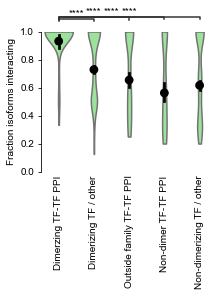

In [7]:
# n for each bar
# axis labels etc.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3, h=4)
violinplot_reflected(data=n_iso_per_ppi,
              x='dimer_cat',
              y='f_iso_positive',
              inner=None,
              cut=0,
              color='lightgreen',
              order=cats,
              ax=ax)

pairs_to_test = [(cats[0], cat) for cat in cats[1:]]
annotator = Annotator(ax=ax, pairs=pairs_to_test, data=n_iso_per_ppi, x='dimer_cat', y='f_iso_positive', order=cats)
annotator.configure(loc='outside')
# TODO: set this programmatically
annotator.annotate_custom_annotations(['****',
                                       '****',
                                       '****',
                                       '****'])

# TODO: set the statistic and error bar calculation
sns.pointplot(data=n_iso_per_ppi,
              x='dimer_cat',
              y='f_iso_positive',
              order=cats,
              color='black',
              linestyles='',
              ax=ax)
ax.set_ylabel('Fraction isoforms interacting')
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.savefig('../figures/n_iso_ppi_by_dimer_cat.pdf',
            bbox_inches='tight')

In [8]:
# look for examples (CREB5 is current best bet)
ppi['ad_tf_family'] = ppi['ad_gene_symbol'].map(tf_fam)
ppi['db_tf_family'] = ppi['db_gene_symbol'].map(tf_fam)
ppi.loc[ppi['ad_tf_family'].isin(DIMERIZING_TF_FAMILIES) &
        (ppi['ad_tf_family'] == ppi['db_tf_family']),
         'ad_gene_symbol'].value_counts()

TCF4      96
TCF12     30
ATF2      18
DDIT3     10
E2F3       6
ARNTL2     6
SMAD4      4
PPARG      4
ESRRG      4
NFE2L2     4
GRHL3      3
FOS        2
NR4A2      2
CREB5      2
RFX4       2
RARB       2
ARNT2      2
ESRRA      2
FOSB       2
Name: ad_gene_symbol, dtype: int64

In [9]:
# break down TF-TF by large family + others. 
# Do within family and one bar for between family

In [10]:
n_iso_per_ppi['dimer_cat'].value_counts()

Non-dimerizing TF / other    300
Dimerizing TF / other        255
Outside family TF-TF PPI     109
Non-dimer TF-TF PPI           70
Dimerzing TF-TF PPI           52
Name: dimer_cat, dtype: int64

In [11]:
# TODO check if it's dominated by one gene
print(n_iso_per_ppi.loc[n_iso_per_ppi['dimer_cat'] == cats[0], :].shape[0],
      'PPIs\n',
      n_iso_per_ppi.loc[n_iso_per_ppi['dimer_cat'] == cats[0], 'ad_gene_symbol'].nunique(),
      'TF genes\n',
      n_iso_per_ppi.loc[n_iso_per_ppi['dimer_cat'] == cats[0], :]
        .drop_duplicates(subset=['ad_gene_symbol'])
        ['n_iso_successfully_tested'].sum(),
        'isoforms\n')
print(n_iso_per_ppi.loc[n_iso_per_ppi['dimer_cat'] == cats[0], :]
.drop_duplicates(subset=['ad_gene_symbol'])
['ad_tf_family'].value_counts())
print()
print(n_iso_per_ppi.loc[n_iso_per_ppi['dimer_cat'] == cats[0], :]
      .groupby('ad_gene_symbol')
      .size()
      .sort_values(ascending=False))

52 PPIs
 19 TF genes
 49 isoforms

bZIP                6
Nuclear receptor    5
bHLH                4
E2F                 1
Grainyhead          1
RFX                 1
SMAD                1
Name: ad_tf_family, dtype: int64

ad_gene_symbol
TCF4      12
TCF12     10
DDIT3      5
ATF2       3
E2F3       3
PPARG      2
SMAD4      2
ESRRG      2
ARNTL2     2
NFE2L2     2
RFX4       1
RARB       1
ARNT2      1
NR4A2      1
GRHL3      1
FOS        1
ESRRA      1
CREB5      1
FOSB       1
dtype: int64


In [12]:
# permutation test
cats = [
 'Dimerzing TF-TF PPI',
 'Dimerizing TF / other',
 'Outside family TF-TF PPI',
 'Non-dimer TF-TF PPI',
 'Non-dimerizing TF / other',
 ]

n_iso_filt = n_iso_per_ppi.loc[~n_iso_per_ppi['ad_gene_symbol'].isin(['TCF12', 'TCF4']),
                                  :].copy().reset_index(drop=True)

rnd_vals = {}
obs_val = {}
for cat in cats[1:]:
    rnd_vals[cat] = []
    obs_val[cat] = (n_iso_filt.loc[n_iso_filt['dimer_cat'] == cats[0], 
                                            'f_iso_positive'].mean() - 
                n_iso_filt.loc[n_iso_filt['dimer_cat'] == cat, 
                                            'f_iso_positive'].mean())
for _i in range(10000):
    rand_cats = n_iso_filt['dimer_cat'].sample(frac=1).reset_index(drop=True)  # equivalent to shuffle
    for cat in cats[1:]:
        rnd_vals[cat].append(n_iso_filt.loc[rand_cats == cats[0], 
                                            'f_iso_positive'].mean() - 
                            n_iso_filt.loc[rand_cats == cat, 
                                            'f_iso_positive'].mean())

pvals = {}
for cat in cats[1:]:
    pvals[cat] = sum(v >= obs_val[cat] for v in rnd_vals[cat]) / len(rnd_vals[cat])
pvals

{'Dimerizing TF / other': 0.0103,
 'Outside family TF-TF PPI': 0.0,
 'Non-dimer TF-TF PPI': 0.0,
 'Non-dimerizing TF / other': 0.0}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Dimerzing TF-TF PPI vs. Dimerizing TF / other: **
Dimerzing TF-TF PPI vs. Outside family TF-TF PPI: ****
Dimerzing TF-TF PPI vs. Non-dimer TF-TF PPI: ****
Dimerzing TF-TF PPI vs. Non-dimerizing TF / other: ****


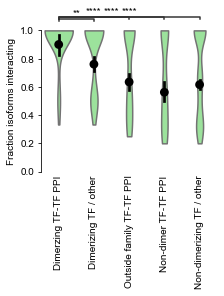

In [13]:
# Remove hubs
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3, h=4)
violinplot_reflected(data=n_iso_per_ppi.loc[~n_iso_per_ppi['ad_gene_symbol'].isin(['TCF12', 'TCF4']), :],
              x='dimer_cat',
              y='f_iso_positive',
              inner=None,
              cut=0,
              color='lightgreen',
              order=cats,
              ax=ax)

pairs_to_test = [(cats[0], cat) for cat in cats[1:]]
annotator = Annotator(ax=ax, pairs=pairs_to_test, data=n_iso_per_ppi, x='dimer_cat', y='f_iso_positive', order=cats)
annotator.configure(loc='outside')
# TODO: set this programmatically
annotator.annotate_custom_annotations(['**',
                                       '****',
                                       '****',
                                       '****'])

# TODO: set the statistic and error bar calculation
sns.pointplot(data=n_iso_per_ppi.loc[~n_iso_per_ppi['ad_gene_symbol'].isin(['TCF12', 'TCF4']), :],
              x='dimer_cat',
              y='f_iso_positive',
              order=cats,
              color='black',
              linestyles='',
              ax=ax)
ax.set_ylabel('Fraction isoforms interacting')
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.savefig('../figures/n_iso_ppi_by_dimer_cat_exclude_TCF4_TCF12.pdf',
            bbox_inches='tight')

In [14]:
def delta_n_D_or_E(row):
    if row['gene_symbol'] not in tfs:
        return np.nan
    aa_ref = tfs[row['gene_symbol']][row['clone_name_ref']].aa_seq
    aa_alt = tfs[row['gene_symbol']][row['clone_name_alt']].aa_seq
    return  (aa_alt.count('D') + aa_alt.count('E')) - (aa_ref.count('D') + aa_ref.count('E'))

df['delta_n_D_or_E'] = df.apply(delta_n_D_or_E, axis=1)

PearsonRResult(statistic=0.06481058058564054, pvalue=0.24251644429935107)


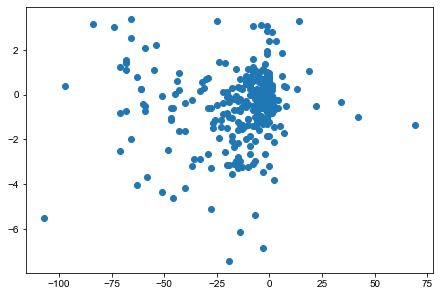

In [15]:
fig, ax = plt.subplots(1, 1)
y, x = df.loc[:, ['activation_fold_change_log2', 'delta_n_D_or_E']].dropna().values.T
ax.scatter(x, y)
print(stats.pearsonr(x, y))


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


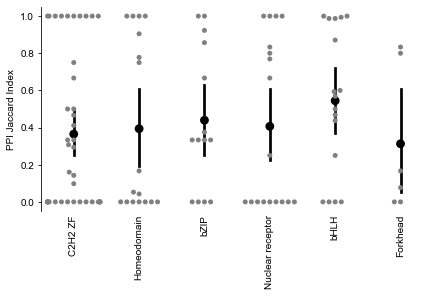

In [16]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=df.loc[df['family'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor', 'bZIP', 'Forkhead'])],
              x='family',
              y='PPI_jaccard',
              color='grey',
              ax=ax)
sns.pointplot(data=df.loc[df['family'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor', 'bZIP', 'Forkhead'])],
              x='family',
              y='PPI_jaccard',
              color='black',
              linestyles='',
              ax=ax)
ax.set_ylabel('PPI Jaccard Index')
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.savefig('../figures/PPI-Jaccard_by-TF-family.pdf',
            bbox_inches='tight')

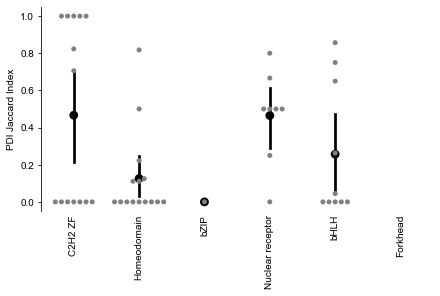

In [17]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=df.loc[df['family'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor', 'bZIP', 'Forkhead'])],
              x='family',
              y='PDI_jaccard',
              color='grey',
              ax=ax)
sns.pointplot(data=df.loc[df['family'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor', 'bZIP', 'Forkhead'])],
              x='family',
              y='PDI_jaccard',
              color='black',
              linestyles='',
              ax=ax)
ax.set_ylabel('PDI Jaccard Index')
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.savefig('../figures/PDI-Jaccard_by-TF-family.pdf',
            bbox_inches='tight')

In [18]:
ppi['tf_family_ad'] = ppi['ad_gene_symbol'].map(tf_fam)
ppi['tf_family_db'] = ppi['db_gene_symbol'].map(tf_fam)

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 67.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 70.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

Text(0.5, 0, '')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


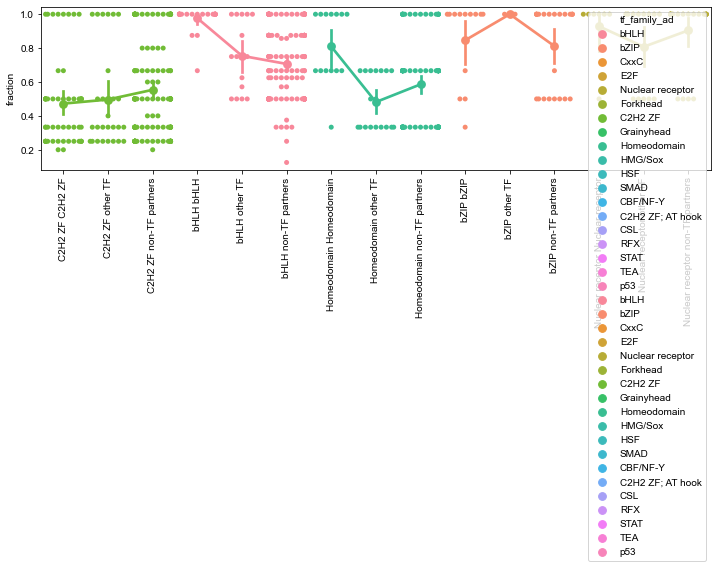

In [19]:
# by tf family
# split partners by within family, other TF, non-tf
# plot fraction of isoforms the partner interacts with?

# change to percent of isoforms loosing PPI?
f =(ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
        ['Y2H_result']
        .mean()
        .to_frame(name='fraction')  # TODO improve name
        .reset_index())
f['tf_family_ad'] = f['ad_gene_symbol'].map(tf_fam)
f['tf_family_db'] = f['db_gene_symbol'].map(tf_fam)
# consolodate into other families?
fams_to_plot = [
                'C2H2 ZF', 
                'bHLH',
                 'Homeodomain',
                  'bZIP',
                   'Nuclear receptor',
                    #'HMG/Sox',
                    #'Forkhead',
                    #'Grainyhead',
                    #'E2F',
                    ]
f['cat'] = 'Unassigned'
for fam in fams_to_plot:
    f.loc[(f['tf_family_ad'] == fam) & (f['tf_family_db'] == fam), 'cat'] = fam + ' ' + fam
    f.loc[(f['tf_family_ad'] == fam) & (f['tf_family_db'] != fam) & f['tf_family_db'].notnull(), 'cat'] = fam + ' other TF'
    f.loc[(f['tf_family_ad'] == fam) & f['tf_family_db'].isnull(), 'cat'] = fam + ' non-TF partners'


order = [fam + ' ' + x for fam in fams_to_plot for x in [fam, 'other TF', 'non-TF partners']]
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=12, h=3)
sns.pointplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
sns.swarmplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')

Text(0.5, 0, '')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


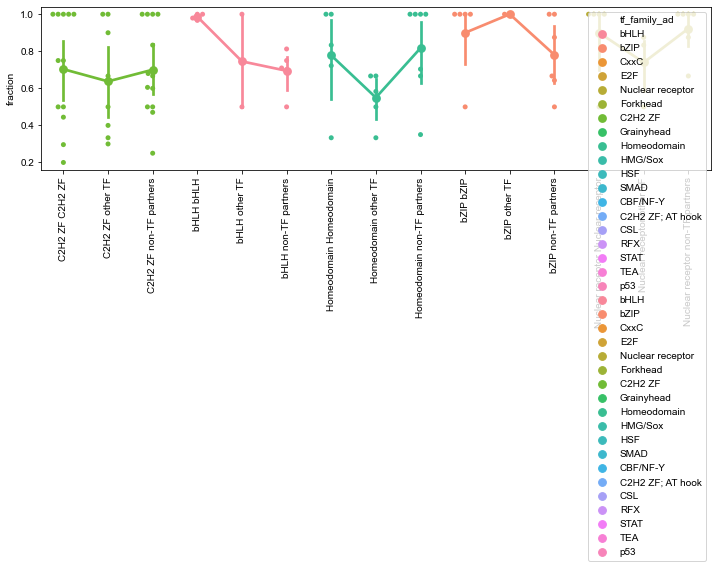

In [20]:
# average over gene
f = f.groupby(['ad_gene_symbol', 'cat'])['fraction'].mean().reset_index()
f['tf_family_ad'] = f['ad_gene_symbol'].map(tf_fam)
order = [fam + ' ' + x for fam in fams_to_plot for x in [fam, 'other TF', 'non-TF partners']]
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=12, h=3)
sns.pointplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
sns.swarmplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')

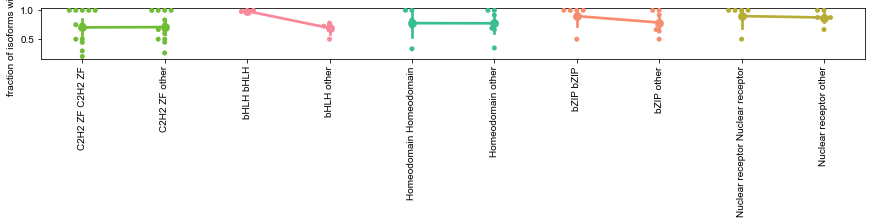

In [21]:
f =(ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
        ['Y2H_result']
        .mean()
        .to_frame(name='fraction')  # TODO improve name
        .reset_index())
f['tf_family_ad'] = f['ad_gene_symbol'].map(tf_fam)
f['tf_family_db'] = f['db_gene_symbol'].map(tf_fam)
f['cat'] = 'Unassigned'
for fam in fams_to_plot:
    f.loc[(f['tf_family_ad'] == fam) & (f['tf_family_db'] == fam), 'cat'] = fam + ' ' + fam
    f.loc[(f['tf_family_ad'] == fam) & (f['tf_family_db'] != fam) & f['tf_family_db'].notnull(), 'cat'] = fam + ' other'
    f.loc[(f['tf_family_ad'] == fam) & f['tf_family_db'].isnull(), 'cat'] = fam + ' other'

f = f.groupby(['ad_gene_symbol', 'cat'])['fraction'].mean().reset_index()
f['tf_family_ad'] = f['ad_gene_symbol'].map(tf_fam)
order = [fam + ' ' + x for fam in fams_to_plot for x in [fam, 'other']]
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=12, h=3)
sns.pointplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
sns.swarmplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('fraction of isoforms with PPI')
ax.get_legend().remove()
fig.savefig('../figures/pct-isoforms-PPI_by-family.pdf', bbox_inches='tight')
# lose legend
# lose error bar
# add p-value

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small 

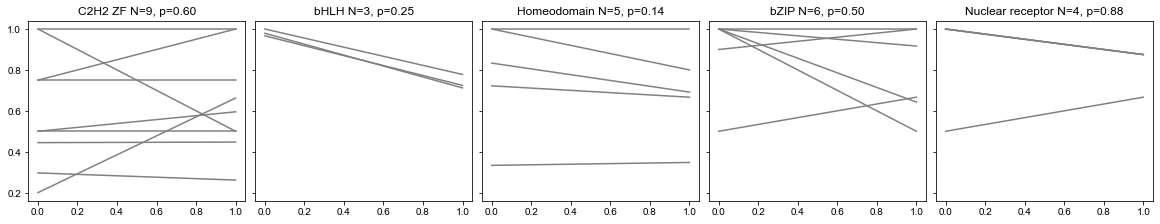

In [22]:
# find bHLH that have both bHLH and other partner
# take average fraction of bHLH and fraction of other partner lost
f =(ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
        ['Y2H_result']
        .mean()
        .to_frame(name='fraction')  # TODO improve name
        .reset_index())
f['tf_family_ad'] = f['ad_gene_symbol'].map(tf_fam)
f['tf_family_db'] = f['db_gene_symbol'].map(tf_fam)
f['same_family'] = (f['tf_family_ad'] == f['tf_family_db'])
f = f.groupby(['ad_gene_symbol', 'same_family', 'tf_family_ad'])['fraction'].mean().reset_index()

f = f.pivot(values='fraction', columns=['same_family'], index=['ad_gene_symbol', 'tf_family_ad'])
f = f.dropna().reset_index().rename(columns={True: 'same family', False: 'different partner'})

fig, axs = plt.subplots(1, len(fams_to_plot), sharey=True)
fig.set_size_inches(w=16, h=3)

for fam, ax in zip(fams_to_plot, axs):
    paired_data = f.loc[f['tf_family_ad'] == fam, ['same family', 'different partner']].values
    for pair in paired_data:
        ax.plot([0, 1], 
                pair,
                color='grey')
    ax.set_title(f'{fam} N={paired_data.shape[0]}, p={stats.wilcoxon(paired_data[:, 0], paired_data[:, 1])[1]:.2f}')

In [23]:
# p-value, n
stats.wilcoxon(paired_data[:, 0], paired_data[:, 1])

WilcoxonResult(statistic=4.0, pvalue=0.875)

In [24]:
# to get p-value
# for each gene calculate mean of TF-TF dimer PPI interacting isoforms - mean of other PPI interacting isoforms
# take mean of that difference
# simulate by shuffling partner names

In [25]:
y2h.loc[(y2h['ad_gene_symbol'].map(tf_fam) == 'Nuclear receptor') & (y2h['db_gene_symbol'].map(tf_fam) == 'Nuclear receptor'), 'ad_gene_symbol'].unique()

array(['RXRA', 'RARB', 'NR4A1', 'NR1H3', 'RXRG', 'RARG', 'NR2F2', 'PPARD',
       'NR4A2', 'PPARG', 'HNF4A', 'ESRRG', 'ESRRA'], dtype=object)

In [26]:
y2h.loc[(y2h['ad_gene_symbol'].map(tf_fam) == 'bZIP') & (y2h['db_gene_symbol'].map(tf_fam) == 'bZIP'), 'ad_gene_symbol'].unique()

array(['ATF2', 'CREB5', 'NFE2L2', 'FOS', 'FOSB', 'DDIT3'], dtype=object)

In [27]:
print(ppi['Y2H_result'].notnull().sum())
print((ppi['Y2H_result'] == True).sum())
print(ppi.loc[ppi['Y2H_result'].notnull(), 'ad_clone_acc'].nunique())
print(ppi.loc[ppi['Y2H_result'].notnull(), 'ad_gene_symbol'].nunique())
print(ppi.loc[ppi['Y2H_result'].notnull(), 'db_gene_symbol'].nunique())

3045
2047
166
63
500


In [28]:
# rewiring fraction
df = ppi.copy()
partners = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result']
              .mean()
              .reset_index()
              .groupby('db_gene_symbol')
              .mean()
              .rename(columns={'Y2H_result': 'rewiring_score'}))
partners['rewiring_score'] = 1. - partners['rewiring_score']
partners['rewiring_score_alt'] = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result']
                                    .all()
                                    .reset_index()
                                    .groupby('db_gene_symbol')
                                    .mean())
partners['rewiring_score_alt'] = 1. - partners['rewiring_score_alt']
partners['degree'] = (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['Y2H_result'] == True),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())
partners['degree_filtered'] = (df.loc[(df['Y2H_result'] == True),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())
cats = load_ppi_partner_categories()
cats = cats.groupby('category')['gene_symbol_partner'].apply(set).to_dict()
for cat, members in cats.items():
    partners['is_partner_category_' + '_'.join(cat.split())] = partners.index.isin(members)
if partners.isnull().any().any():
    raise ValueError('Did not expect missing data')

<ipython-input-28-f0d8f00b5c41>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  partners = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result']
<ipython-input-28-f0d8f00b5c41>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  partners['rewiring_score_alt'] = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result']


In [29]:
ubq = huri.load_ubq_genes()
id_map = (huri.load_id_map('ensembl_gene_id', 'hgnc_symbol')
          .drop_duplicates('ensembl_gene_id')
          .set_index('ensembl_gene_id')
          ['hgnc_symbol'])
ubq = {k: {id_map[g] for g in v} for k, v in ubq.items()}
[(k, partners.index.isin(v).sum()) for k, v in ubq.items()]
partners['is_partner_category_E3_UBQ'] = partners.index.isin(ubq['E3_adaptor'].union(ubq['E3_activity']))
partners['is_partner_category_UBQ'] = partners.index.isin(set.union(*ubq.values()))

kinases = pd.read_html('../data/external/KinHub.htm')[0]['HGNC Name'].unique()
partners['is_partner_category_kinase'] = partners.index.isin(kinases)

In [30]:
partners.head()

,rewiring_score,rewiring_score_alt,degree,degree_filtered,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport,is_partner_category_E3_UBQ,is_partner_category_UBQ,is_partner_category_kinase
db_gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,
A1CF,0.428571,1.000000,1,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ACOT12,0.708333,1.000000,2,2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
AEBP2,0.333333,1.000000,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
AES,0.298611,0.833333,10,6,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
AGR2,0.500000,1.000000,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


                    rewiring_score  rewiring_score_alt
rewiring_score            1.000000            0.835828
rewiring_score_alt        0.835828            1.000000


<AxesSubplot: xlabel='rewiring_score', ylabel='rewiring_score_alt'>

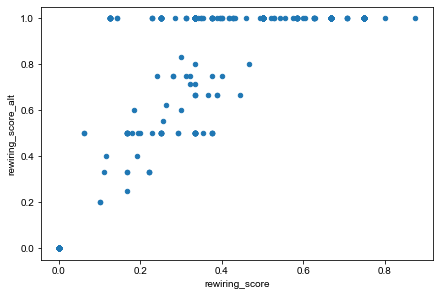

In [31]:
print(partners[['rewiring_score', 'rewiring_score_alt']].corr())
partners.plot.scatter(x='rewiring_score', y='rewiring_score_alt')

In [32]:
cat_columns = [c for c in partners.columns if c.startswith('is_partner_category_') and partners[c].any()]
partners[cat_columns].sum().sort_values(ascending=False)

is_partner_category_TF                     128
is_partner_category_cofactor                78
is_partner_category_signaling               65
is_partner_category_UBQ                     44
is_partner_category_other                   39
is_partner_category_E3_UBQ                  37
is_partner_category_cytoskeleton            29
is_partner_category_protein_turnover        28
is_partner_category_metabolism              26
is_partner_category_RNA_processing          26
is_partner_category_cell_cycle              22
is_partner_category_vesicle_transport       19
is_partner_category_kinase                  18
is_partner_category_DNA_repair              16
is_partner_category_cell-cell_signaling      7
is_partner_category_RNA_turnover             7
is_partner_category_translation              7
is_partner_category_nuclear_transport        3
is_partner_category_DNA_replication          3
is_partner_category_DNA_polymerase           2
is_partner_category_membrane_protein         1
dtype: int64

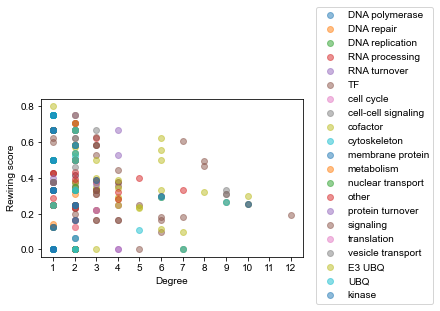

In [33]:
fig, ax = plt.subplots(1, 1)
# order categories by size
for cat in cat_columns:
    ax.scatter(partners.loc[partners[cat],
                             'degree'],
                partners.loc[partners[cat],
                             'rewiring_score'],
               label=cat[len('is_partner_category_'):].replace('_', ' '),
               alpha=0.5)
ax.set_xticks(range(1, partners['degree'].max() + 1))
ax.set_xlabel('Degree')
ax.set_ylabel('Rewiring score')
ax.legend(loc=[1.05, -0.3])

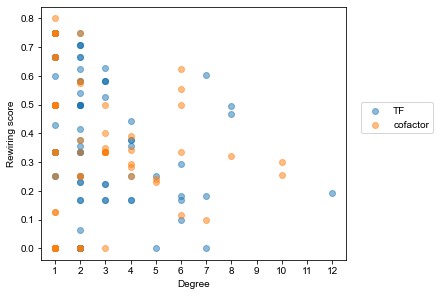

In [34]:
fig, ax = plt.subplots(1, 1)
# order categories by size
min_partners = 75
for cat in cat_columns:
    if partners[cat].sum() < min_partners:
        continue
    ax.scatter(partners.loc[partners[cat],
                             'degree'],
                partners.loc[partners[cat],
                             'rewiring_score'],
               label=cat[len('is_partner_category_'):].replace('_', ' '),
               alpha=0.5)
ax.set_xticks(range(1, partners['degree'].max() + 1))
ax.set_xlabel('Degree')
ax.set_ylabel('Rewiring score')
ax.legend(loc=[1.05, 0.5])

In [35]:
# TEMP: take KRTAPs out of cytoskeleton
# TODO: fix the file
partners.loc[partners.index.str.startswith('KRTAP'), 'is_partner_category_cytoskeleton'] = False
partners.loc[partners.index.str.startswith('KRTAP'), 'is_partner_category_other'] = True

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 49.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 42.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 36.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

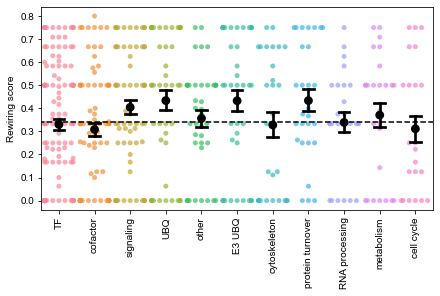

In [36]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_category.pdf',
            bbox_inches='tight')

In [37]:
id_map

ensembl_gene_id
ENSG00000210049        MT-TF
ENSG00000211459      MT-RNR1
ENSG00000210077        MT-TV
ENSG00000210082      MT-RNR2
ENSG00000209082       MT-TL1
                     ...    
ENSG00000284208         NCR1
ENSG00000284279    RNU6-222P
ENSG00000283827      KIR3DL1
ENSG00000283846      KIR2DS4
ENSG00000283951      KIR3DL2
Name: hgnc_symbol, Length: 40583, dtype: object

In [38]:
def load_reactome_gene_to_pathway():
    """Ensemble Gene IDs -> lowest level reactome pathways
    Returns:
        pandas.DataFrame: one row per gene/pathway combination
    """
    pth = Path('../data/external/Ensembl2Reactome_All_Levels.txt')
    data = pd.read_csv(pth,
                       sep='\t',
                       names=['ensembl_id',
                              'reactome_pathway_id',
                              'url',
                              'pathway_name',
                              'evidence_code',
                              'species'])
    data = (data.loc[data['ensembl_id'].str.startswith('ENSG') &
                     (data['species'] == 'Homo sapiens'),
                     ['ensembl_id',
                      'reactome_pathway_id',
                      'pathway_name',
                      'evidence_code']]
                .rename(columns={'ensembl_id': 'ensembl_gene_id'}))
    return data

In [39]:
reactome = load_reactome_gene_to_pathway()
reactome['hgnc_gene_symbol'] = reactome['ensembl_gene_id'].map(id_map)
for pathway_name, count in reactome['pathway_name'].value_counts().iteritems():
    if count >= 20:
        pathway_genes = reactome.loc[reactome['pathway_name'] == pathway_name, 
                                    'hgnc_gene_symbol'].unique()
        partners['is_partner_pathway_' + pathway_name] = partners.index.isin(pathway_genes)

<ipython-input-39-8f5e4531dafd>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for pathway_name, count in reactome['pathway_name'].value_counts().iteritems():
<ipython-input-39-8f5e4531dafd>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  partners['is_partner_pathway_' + pathway_name] = partners.index.isin(pathway_genes)
<ipython-input-39-8f5e4531dafd>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  partners['is_partner_pathway_' + pathway_name] = partners.index.isin(pa

In [40]:
pathway_columns = [c for c in partners.columns if c.startswith('is_partner_pathway_')]
partners[pathway_columns].sum().sort_values(ascending=False)

is_partner_pathway_Gene expression (Transcription)       83
is_partner_pathway_RNA Polymerase II Transcription       75
is_partner_pathway_Generic Transcription Pathway         69
is_partner_pathway_Signal Transduction                   68
is_partner_pathway_Metabolism of proteins                62
                                                         ..
is_partner_pathway_Calnexin/calreticulin cycle            0
is_partner_pathway_Cargo concentration in the ER          0
is_partner_pathway_Nicotinate metabolism                  0
is_partner_pathway_Signalling to RAS                      0
is_partner_pathway_Metabolism of fat-soluble vitamins     0
Length: 1143, dtype: int64

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 54.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 52.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 49.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

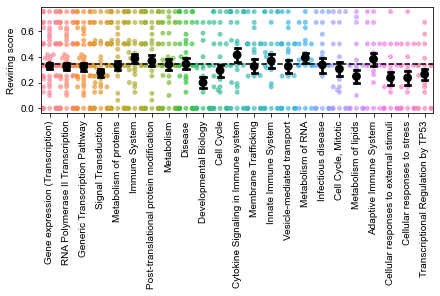

In [41]:
x = partners.loc[:, pathway_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_pathway_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_pathway.pdf',
            bbox_inches='tight')

In [42]:
# subcellular location

subcell = huri.load_subcellular_location()
subcell['hgnc_symbol'] = subcell.index.map(id_map)
subcell = subcell.groupby('hgnc_symbol').any()
for compartment in subcell.columns:
    compartment_genes = subcell[subcell[compartment]].index.values
    partners['is_partner_compartment_' + compartment[3:]] = partners.index.isin(compartment_genes)

In [43]:
compartment_columns = [c for c in partners.columns if c.startswith('is_partner_compartment_')]
partners[compartment_columns].sum().sort_values(ascending=False)

is_partner_compartment_Nucleoplasm                      149
is_partner_compartment_Cytosol                          145
is_partner_compartment_Nucleus                           71
is_partner_compartment_Plasma membrane                   45
is_partner_compartment_Vesicles                          37
is_partner_compartment_Nucleoli                          36
is_partner_compartment_Nuclear speckles                  27
is_partner_compartment_Nuclear bodies                    18
is_partner_compartment_Mitochondria                      17
is_partner_compartment_Golgi apparatus                   17
is_partner_compartment_Intermediate filaments             9
is_partner_compartment_Microtubules                       7
is_partner_compartment_Centrosome                         7
is_partner_compartment_Endoplasmic reticulum              6
is_partner_compartment_Nuclear membrane                   6
is_partner_compartment_Actin filaments                    6
is_partner_compartment_Cytokinetic bridg

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 59.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 55.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

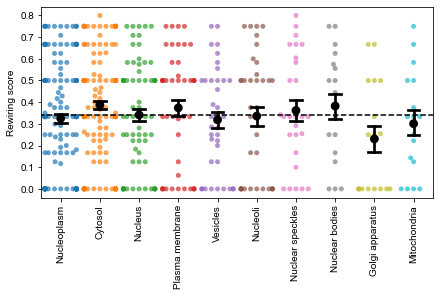

In [44]:
x = partners.loc[:, compartment_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_compartment_'):].replace('_', ' '))
min_n_category = 10
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_subcellular_compartment.pdf',
            bbox_inches='tight')

In [45]:
# gene age
age = huri.load_gene_age().to_frame()
age['hgnc_symbol'] = age.index.map(id_map)
age = age.dropna()
age = age.drop_duplicates('hgnc_symbol')
age = age.set_index('hgnc_symbol')['gene_age']

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/ccsblib/huri/internal_data/ID_mapping.py:175: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(qry, paros_connection())


In [46]:
for age_category in age.unique():
    genes_list = age[age == age_category].index.values
    partners['is_partner_age_' + age_category] = partners.index.isin(genes_list)

In [47]:
age_columns = ['is_partner_age_' + c for c in age.dtype.categories]
partners[age_columns].sum().sort_values(ascending=False)

is_partner_age_Eukaryota             165
is_partner_age_Eumetazoa             140
is_partner_age_Vertebrata             55
is_partner_age_Opisthokonta           41
is_partner_age_Mammalia               36
is_partner_age_Euk+Bac                29
is_partner_age_Cellular_organisms     21
is_partner_age_Euk_Archaea             6
dtype: int64

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 45.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 56.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWa

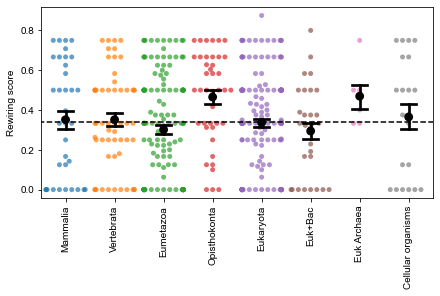

In [48]:
x = partners.loc[:, age_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_age_'):].replace('_', ' '))
min_n_category = 0
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=[c.replace('_', ' ') for c in age.dtype.categories],
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=[c.replace('_', ' ') for c in age.dtype.categories],
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_subcellular_gene_age.pdf',
            bbox_inches='tight')

In [49]:
def load_cancer_driver_gene_compendium():
    """
    From intogen.org
    Martinez-Jimenez et al. Nature Reviews Cancer, 2020
    """
    return set(pd.read_csv('../data/external/Compendium_Cancer_Genes.tsv', sep='\t')['SYMBOL'].unique())

cdg = load_cancer_driver_gene_compendium()

In [50]:
def load_cancer_gene_census():
    return set(pd.read_csv('../data/external/cancer_gene_census.csv')['Gene Symbol'].values)

cgc = load_cancer_gene_census()
len(cgc)

723

In [51]:
len(cgc.intersection(cdg))

416

In [52]:
def load_omim_genes():
    omim = pd.read_table('../data/external/OMIM_genemap2.txt',
                         names=['Chromosome',
                                'Genomic Position Start',
                                'Genomic Position End',
                                'Cyto Location',
                                'Computed Cyto Location',
                                'Mim Number',
                                'Gene Symbols',
                                'Gene Name',
                                'Approved Symbol',
                                'Entrez Gene ID',
                                'Ensembl Gene ID',
                                'Comments',
                                'Phenotypes',
                                'Mouse Gene Symbol/ID'],
                         comment='#')
    # the file contains all genes, so filter for those
    # with disease annotation
    return set(omim.loc[omim['Phenotypes'].notnull() & omim['Approved Symbol'].notnull(), 'Approved Symbol'].unique())


omim = load_omim_genes()

In [53]:
partners['is_partner_disease_OMIM'] = partners.index.isin(omim)
partners['is_partner_disease_Cancer_Gene_Census'] = partners.index.isin(cgc)
partners['is_partner_disease_Cancer_Driver_Compendium'] = partners.index.isin(cdg)

In [54]:
disease_columns = [c for c in partners.columns if c.startswith('is_partner_disease_')]
partners[disease_columns].sum().sort_values(ascending=False)

is_partner_disease_OMIM                        121
is_partner_disease_Cancer_Gene_Census           31
is_partner_disease_Cancer_Driver_Compendium     27
dtype: int64

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


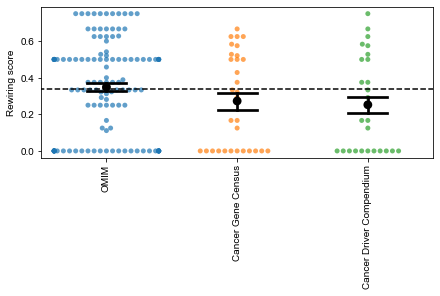

In [55]:
x = partners.loc[:, disease_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_disease_'):].replace('_', ' '))
min_n_category = 10
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_disease.pdf',
            bbox_inches='tight')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 61.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 65.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 60.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

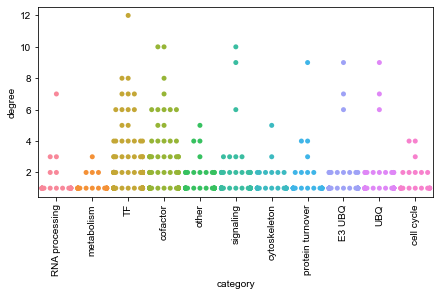

In [56]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['degree'] = x.index.map(partners['degree'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['degree'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='degree',
              ax=ax)
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90);

In [57]:
partners['rewiring_score_alt'].mean()

0.685218253968254

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 53.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 57.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 79.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

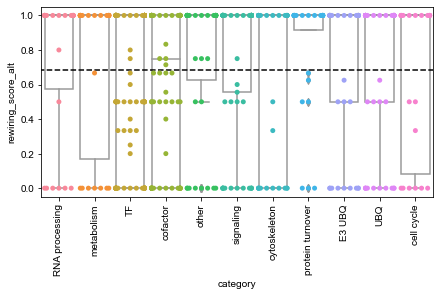

In [58]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score_alt'] = x.index.map(partners['rewiring_score_alt'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['rewiring_score_alt'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=x,
              x='category',
              y='rewiring_score_alt',
               color='white',
             ax=ax)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score_alt',
              ax=ax)
ax.axhline(y=partners['rewiring_score_alt'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90);

In [59]:
uniprot_func = pd.read_excel('../data/internal/20191028- Uniprot functions for interactors.xlsx',
                   sheet_name='Final')
uniprot_func = uniprot_func.loc[uniprot_func['Cofactor type?'].notnull(), ['gene_symbol_partner', 'Cofactor type?']]
if uniprot_func['gene_symbol_partner'].duplicated().any():
    raise UserWarning('unexpected duplicates')
cf_type = uniprot_func.set_index('gene_symbol_partner')['Cofactor type?']
x['cofactor_type'] = x.index.map(cf_type)

In [60]:
x[x.category == 'metabolism']

,category,rewiring_score_alt,cofactor_type
db_gene_symbol,,,
ACOT12,metabolism,1.000000,NaN
ATP5O,metabolism,1.000000,NaN
ATP6V1B2,metabolism,1.000000,NaN
ATPAF2,metabolism,0.000000,NaN
CBS,metabolism,1.000000,NaN
CIAO1,metabolism,1.000000,corepressor
COA5,metabolism,1.000000,NaN
COX5B,metabolism,1.000000,NaN
FLAD1,metabolism,1.000000,NaN


In [61]:
for cat_col in cat_columns:
    print('{}: {:.4f}'.format(
          cat_col[len('is_partner_category_'):].replace('_', ' '),
          stats.mannwhitneyu(partners.loc[partners[cat_col], 'rewiring_score'].values,
                             partners.loc[~partners[cat_col], 'rewiring_score'].values)[1]))

DNA polymerase: 0.9367
DNA repair: 0.2649
DNA replication: 0.2587
RNA processing: 0.9662
RNA turnover: 0.1179
TF: 0.6116
cell cycle: 0.5846
cell-cell signaling: 0.0512
cofactor: 0.1993
cytoskeleton: 0.9109
membrane protein: 0.4987
metabolism: 0.4846
nuclear transport: 0.4434
other: 0.7379
protein turnover: 0.0513
signaling: 0.0415
translation: 0.2905
vesicle transport: 0.1504
E3 UBQ: 0.0209
UBQ: 0.0097
kinase: 0.7558


In [62]:
tf_fam = load_tf_families()

In [63]:
tf_fam.value_counts()

C2H2 ZF             747
Homeodomain         196
bHLH                108
Unknown              69
bZIP                 54
                   ... 
FLYWCH                1
Brinker               1
TCR/CxC               1
Ets; AT hook          1
ARID/BRIGHT; RFX      1
Name: DBD, Length: 65, dtype: int64

In [64]:
tf_fam.loc[tf_fam == 'E2F']

HGNC symbol
E2F1     E2F
E2F2     E2F
E2F3     E2F
E2F4     E2F
E2F5     E2F
E2F6     E2F
E2F7     E2F
E2F8     E2F
TFDP1    E2F
TFDP2    E2F
TFDP3    E2F
Name: DBD, dtype: object

In [65]:
tf_fam.loc[tf_fam == 'Rel']

HGNC symbol
NFAT5     Rel
NFATC1    Rel
NFATC2    Rel
NFATC3    Rel
NFATC4    Rel
NFKB1     Rel
NFKB2     Rel
REL       Rel
RELA      Rel
RELB      Rel
Name: DBD, dtype: object

In [66]:
partners['DBD'] = partners.index.map(tf_fam)

In [67]:
partners.DBD.value_counts()

C2H2 ZF                 41
bHLH                    19
Homeodomain             16
bZIP                     9
Unknown                  7
Nuclear receptor         4
E2F                      3
SMAD                     3
MBD                      3
Forkhead                 2
Homeodomain; POU         2
Ets                      2
HMG/Sox                  2
THAP finger              2
Grainyhead               1
DM                       1
CCCH ZF                  1
C2H2 ZF; Homeodomain     1
C2H2 ZF; AT hook         1
BED ZF                   1
T-box                    1
AP-2                     1
TBP                      1
RFX                      1
TCR/CxC                  1
Pipsqueak                1
C2H2 ZF; BED ZF          1
Name: DBD, dtype: int64

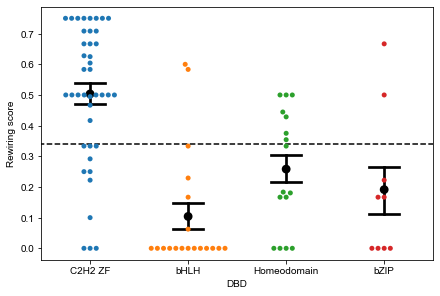

In [68]:
# calculate p-value
dbds_to_plot = ['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']
partners.loc[partners['DBD'].notnull() & ~partners['DBD'].isin(dbds_to_plot), 'DBD'] = 'Other TFs'
partners.loc[partners['DBD'].isnull(), 'DBD'] = 'Not TF'
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=partners.loc[partners['DBD'].isin(dbds_to_plot), :],
            x='DBD',
            y='rewiring_score',
            order=dbds_to_plot,
            ax=ax)
sns.pointplot(data=partners.loc[partners['DBD'].isin(dbds_to_plot), :],
              x='DBD',
              y='rewiring_score',
              order=dbds_to_plot,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_DBD.pdf',
            bbox_inches='tight')

In [69]:
# how to calculate a p-value?
# randomly change each partner DBD label? 
#    - Doesn't work because a single bHLH TF can interact with many bHLH

In [70]:
tf_fam.head()

HGNC symbol
TFAP2A    AP-2
TFAP2B    AP-2
TFAP2C    AP-2
TFAP2D    AP-2
TFAP2E    AP-2
Name: DBD, dtype: object

In [71]:
# TF-TF binding
tftf = ppi.loc[ppi['Y2H_result'] == True, ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().copy()
tftf['ad_dbd'] = tftf['ad_gene_symbol'].map(tf_fam)
tftf['db_dbd'] = tftf['db_gene_symbol'].map(tf_fam)
tftf = tftf.dropna()

In [72]:
tftf.head()

,ad_gene_symbol,db_gene_symbol,ad_dbd,db_dbd
0,ATF2,ATF2,bZIP,bZIP
4,ATF2,JDP2,bZIP,bZIP
39,ATF2,FOSL2,bZIP,bZIP
123,CREB5,FOSL2,bZIP,bZIP
155,GLI1,PIN1,C2H2 ZF,MBD


In [73]:
# TF-TF rewiring
tftf = pd.merge(tftf, 
        (ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result'].apply(lambda x: (x == False).sum()) / 
 ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result'].apply(lambda x: (x.notnull().sum()))).reset_index(),
        how='left',
        on=['ad_gene_symbol', 'db_gene_symbol'])

In [74]:
tftf.loc[tftf['db_dbd'] == 'bHLH', 'ad_gene_symbol'].value_counts()

TCF4      12
TCF12     10
ARNTL2     2
ESRRA      2
MEOX1      2
FOS        1
ZBTB44     1
IKZF2      1
ARNT2      1
ZNF438     1
ESRRG      1
Name: ad_gene_symbol, dtype: int64

In [75]:
tftf.loc[(tftf['db_dbd'] == 'bHLH') & (tftf['ad_dbd'] == 'bHLH'), 'ad_gene_symbol'].value_counts()

TCF4      12
TCF12     10
ARNTL2     2
ARNT2      1
Name: ad_gene_symbol, dtype: int64

In [76]:
tftf.loc[tftf['db_dbd'] == 'bZIP', 'ad_gene_symbol'].value_counts()

DDIT3     5
ATF2      3
NFE2L2    2
CREB5     1
NFYA      1
FOS       1
FOSB      1
Name: ad_gene_symbol, dtype: int64

<ipython-input-77-8fa3d47faf19>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  partners_mod = (df.loc[~df['ad_gene_symbol'].isin(['TCF4', 'TCF12']), :]


0.04675709928723773

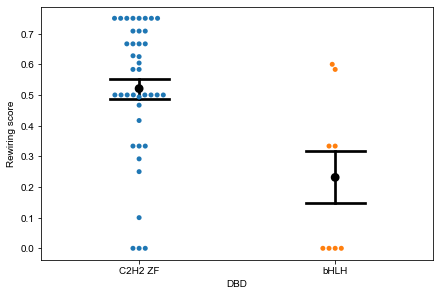

In [77]:
# exclude TCF4 and TCF12 and recalculate
partners_mod = (df.loc[~df['ad_gene_symbol'].isin(['TCF4', 'TCF12']), :]
              .groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result']
              .mean()
              .reset_index()
              .groupby('db_gene_symbol')
              .mean()
              .rename(columns={'Y2H_result': 'rewiring_score'}))
partners_mod['rewiring_score'] = 1. - partners_mod['rewiring_score']
partners_mod['DBD'] = partners_mod.index.map(tf_fam)

fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=partners_mod.loc[partners_mod['DBD'].isin(['C2H2 ZF', 'bHLH']), :],
            x='DBD',
            y='rewiring_score',
            order=['C2H2 ZF', 'bHLH'],
            ax=ax)
sns.pointplot(data=partners_mod.loc[partners_mod['DBD'].isin(['C2H2 ZF', 'bHLH']), :],
              x='DBD',
              y='rewiring_score',
              order=['C2H2 ZF', 'bHLH'],
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_DBD_exclude_TCF4_TCF12.pdf',
            bbox_inches='tight')

stats.mannwhitneyu(partners_mod.loc[partners_mod['DBD'] == 'C2H2 ZF', 'rewiring_score'].values,
                   partners_mod.loc[partners_mod['DBD'] == 'bHLH', 'rewiring_score'].values)[1] * 6

<ipython-input-78-760d0c7dca95>:27: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../figures/TF_TF_correlogram.pdf', bbox_inches='tight')
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


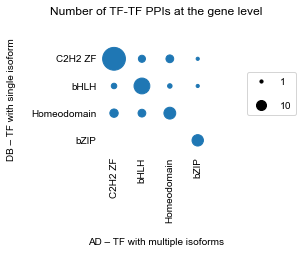

In [78]:
fams = tf_fam.unique()
fams = ['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
scaling = 10
sc = ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y)).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
ax.legend(*sc.legend_elements('sizes',
                              num=[1, 10, 60],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.8, 0.8],
         labelspacing=1.3)
plt.savefig('../figures/TF_TF_correlogram.pdf', bbox_inches='tight')

<ipython-input-79-284160b94528>:23: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../figures/TF_TF_correlogram_homodimers_excluded.pdf', bbox_inches='tight')
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


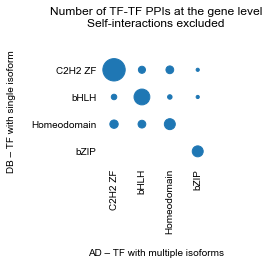

In [79]:
# homodimers excluded
fams = tf_fam.unique()
fams = ['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
scaling = 10
ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y) & (tftf['ad_gene_symbol'] != tftf['db_gene_symbol'])).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level\nSelf-interactions excluded',
             pad=30)
plt.savefig('../figures/TF_TF_correlogram_homodimers_excluded.pdf', bbox_inches='tight')

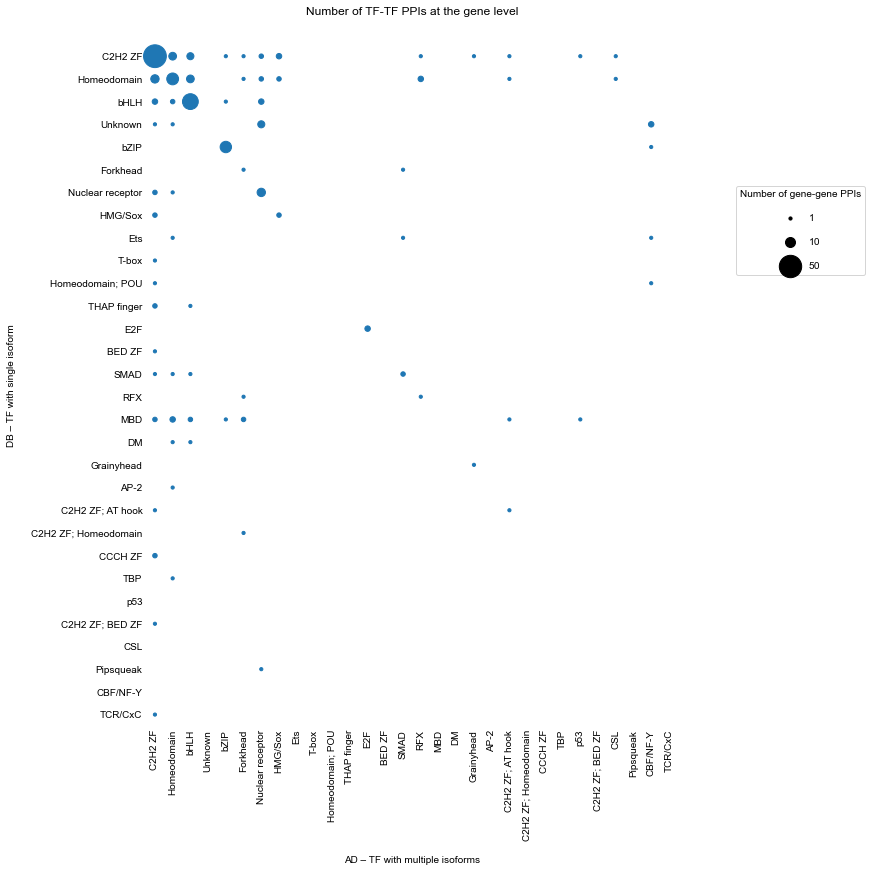

In [80]:
# all families
fams = tf_fam.value_counts().index
fams = list(filter(lambda x: x in tftf['ad_dbd'].unique() or x in tftf['db_dbd'].unique(), fams))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 12)
scaling = 10
sc = ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y)).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
ax.legend(*sc.legend_elements('sizes',
                              num=[1, 10, 50],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.1, 0.8],
         labelspacing=1.3,
          title='Number of gene-gene PPIs')
plt.savefig('../figures/TF_TF_correlogram_all.pdf', bbox_inches='tight')

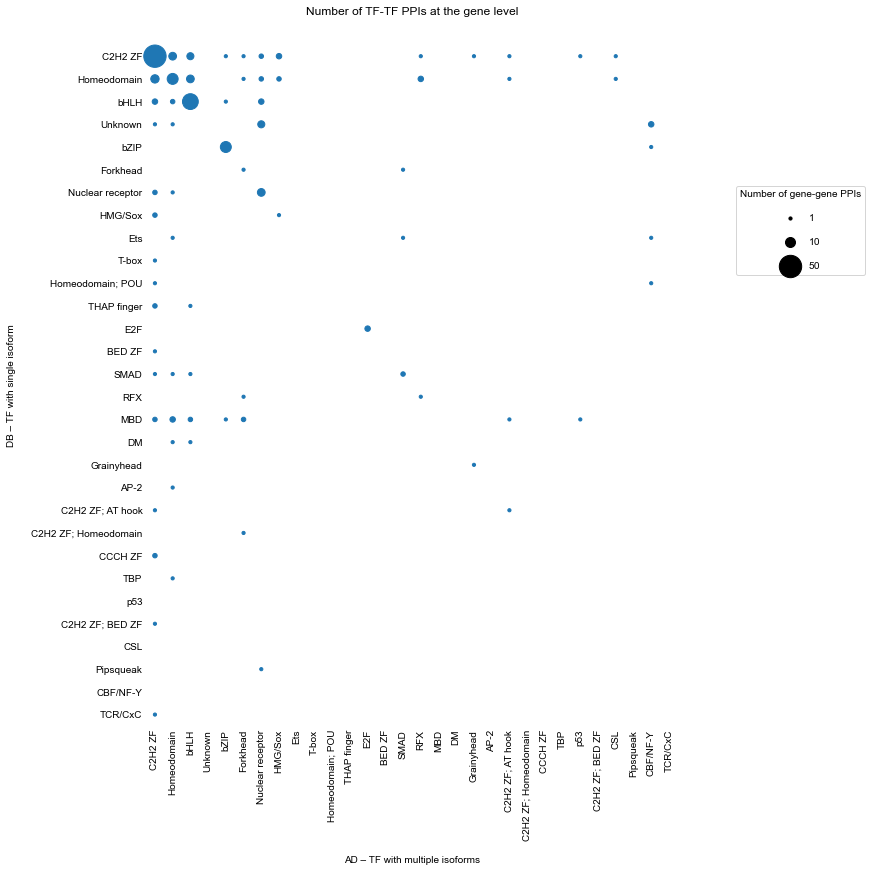

In [81]:
# all families
fams = tf_fam.value_counts().index
fams = list(filter(lambda x: x in tftf['ad_dbd'].unique() or x in tftf['db_dbd'].unique(), fams))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 12)
scaling = 10
sc = ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y) & (tftf['ad_gene_symbol'] != tftf['db_gene_symbol'])).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
ax.legend(*sc.legend_elements('sizes',
                              num=[1, 10, 50],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.1, 0.8],
         labelspacing=1.3,
          title='Number of gene-gene PPIs')
plt.savefig('../figures/TF_TF_correlogram_all_no_homodimers.pdf', bbox_inches='tight')

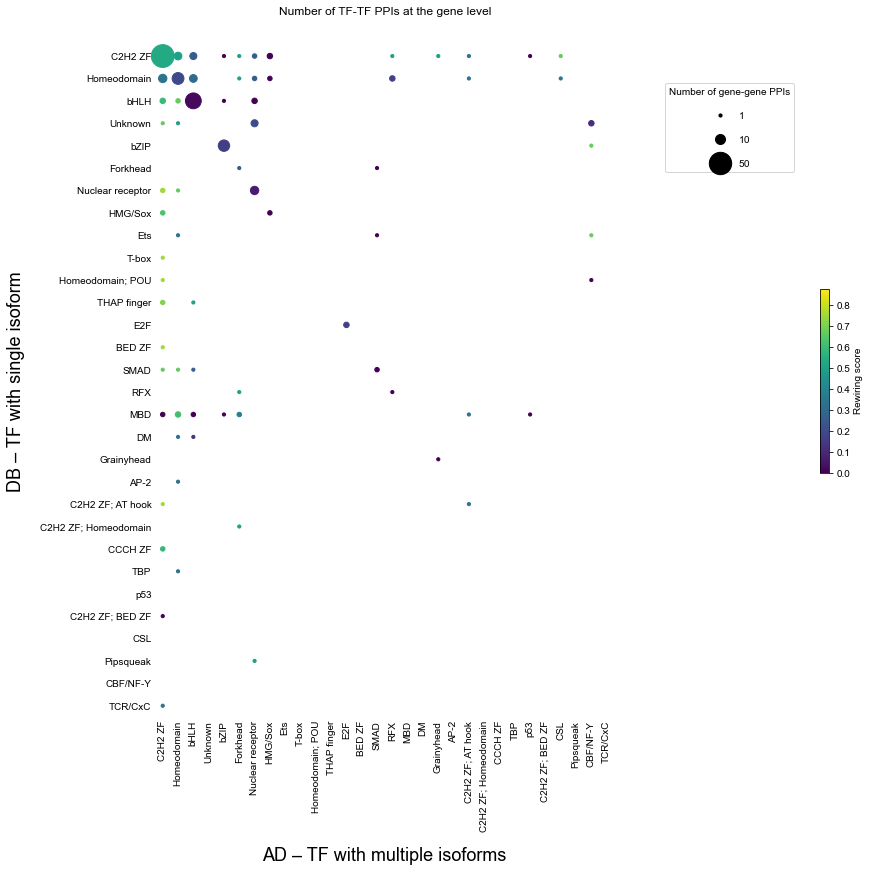

In [82]:
import matplotlib as mpl
# color by rewiring
fams = tf_fam.value_counts().index
fams = list(filter(lambda x: x in tftf['ad_dbd'].unique() or x in tftf['db_dbd'].unique(), fams))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 12)
scaling = 10
sc = ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y)).sum() * scaling for x in fams for y in fams],
           c=[tftf.loc[(tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y), 'Y2H_result'].mean() for x in fams for y in fams],
           cmap='viridis',
           vmin=0,
           vmax=7/8,
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              fontsize=18,
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              fontsize=18,
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
ax.legend(*sc.legend_elements('sizes',
                              num=[1, 10, 50],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.1, 0.95],
         labelspacing=1.3,
          title='Number of gene-gene PPIs')
fig.colorbar(mpl.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=0, vmax=7/8)),
             ax=ax,
             fraction=0.02,
             label='Rewiring score')
plt.savefig('../figures/TF_TF_correlogram_colored_by_rewiring.pdf', bbox_inches='tight')

In [83]:
# what are these unknown DBDs? That interact with NRs...

In [84]:
# examples
# ZBTB48
# ZSCAN12
# FIGLA - TCF12, TCF4, LHX6, 
# MSGN1
partners.loc[partners['DBD'] == 'C2H2 ZF', :].sort_values(['rewiring_score', 'degree_filtered'], ascending=[True, False]).head(5)

,rewiring_score,rewiring_score_alt,degree,degree_filtered,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport,is_partner_category_E3_UBQ,is_partner_category_UBQ,...,is_partner_compartment_Cytoplasmic bodies,is_partner_compartment_Actin filaments,is_partner_compartment_Rods & Rings,is_partner_compartment_Aggresome,is_partner_compartment_Endosomes,is_partner_compartment_Cytokinetic bridge,is_partner_compartment_Microtubules,is_partner_compartment_Microtubule organizing center,is_partner_compartment_Nuclear membrane,is_partner_compartment_Lysosomes,is_partner_compartment_Nuclear bodies,is_partner_compartment_Focal adhesion sites,is_partner_compartment_Peroxisomes,is_partner_age_Eumetazoa,is_partner_age_Eukaryota,is_partner_age_Mammalia,is_partner_age_Cellular_organisms,is_partner_age_Opisthokonta,is_partner_age_Euk+Bac,is_partner_age_Vertebrata,is_partner_age_Euk_Archaea,is_partner_disease_OMIM,is_partner_disease_Cancer_Gene_Census,is_partner_disease_Cancer_Driver_Compendium,DBD
db_gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZBTB25,0.000000,0.000000,7,3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
IKZF1,0.000000,0.000000,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,True,C2H2 ZF
ZNF783,0.000000,0.000000,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,C2H2 ZF
ZNF446,0.100000,0.200000,6,5,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,C2H2 ZF
ZFP69B,0.222222,0.333333,3,3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,C2H2 ZF


In [85]:
ppi.loc[ppi['db_gene_symbol'] == 'FIGLA', 'ad_gene_symbol'].unique()

array(['TCF4'], dtype=object)

In [86]:
ppi.loc[ppi['db_gene_symbol'] == 'MSGN1', 'ad_gene_symbol'].unique()

array(['TCF4', 'ESRRA', 'MEOX1', 'TCF12'], dtype=object)

In [87]:
ppi.loc[ppi['db_gene_symbol'] == 'ZSCAN12', 'ad_gene_symbol'].unique()

array(['ZNF451'], dtype=object)

In [88]:
# statisitcal test (6 is Bonferonni for all pairwise)
# problem with this is that the points are not necessarily indepedent: could all be binding to same TF
stats.mannwhitneyu(partners.loc[partners['DBD'] == 'C2H2 ZF', 'rewiring_score'].values,
                   partners.loc[partners['DBD'] == 'bHLH', 'rewiring_score'].values)[1] * 6

7.704304940347686e-06

In [89]:
stats.mannwhitneyu(partners.loc[(partners['DBD'] == 'C2H2 ZF')
                                & (partners['degree'] == 1),
                                'rewiring_score'].values,
                   partners.loc[(partners['DBD'] == 'bZIP')
                                 & (partners['degree'] == 1),
                                'rewiring_score'].values)

MannwhitneyuResult(statistic=97.5, pvalue=0.02058211540858892)

In [90]:
partners.head()

,rewiring_score,rewiring_score_alt,degree,degree_filtered,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport,is_partner_category_E3_UBQ,is_partner_category_UBQ,...,is_partner_compartment_Cytoplasmic bodies,is_partner_compartment_Actin filaments,is_partner_compartment_Rods & Rings,is_partner_compartment_Aggresome,is_partner_compartment_Endosomes,is_partner_compartment_Cytokinetic bridge,is_partner_compartment_Microtubules,is_partner_compartment_Microtubule organizing center,is_partner_compartment_Nuclear membrane,is_partner_compartment_Lysosomes,is_partner_compartment_Nuclear bodies,is_partner_compartment_Focal adhesion sites,is_partner_compartment_Peroxisomes,is_partner_age_Eumetazoa,is_partner_age_Eukaryota,is_partner_age_Mammalia,is_partner_age_Cellular_organisms,is_partner_age_Opisthokonta,is_partner_age_Euk+Bac,is_partner_age_Vertebrata,is_partner_age_Euk_Archaea,is_partner_disease_OMIM,is_partner_disease_Cancer_Gene_Census,is_partner_disease_Cancer_Driver_Compendium,DBD
db_gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1CF,0.428571,1.000000,1,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,Not TF
ACOT12,0.708333,1.000000,2,2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Not TF
AEBP2,0.333333,1.000000,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
AES,0.298611,0.833333,10,6,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Not TF
AGR2,0.500000,1.000000,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Not TF


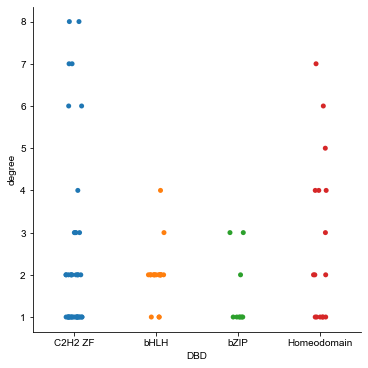

In [91]:
# is it a degree thing?
sns.catplot(data=partners.loc[partners['DBD'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']), :],
            x='DBD', y='degree')

In [92]:
# could take an example of very reqired ZF

In [93]:
# Is it that ZF are more rewired or the others are less, or both?



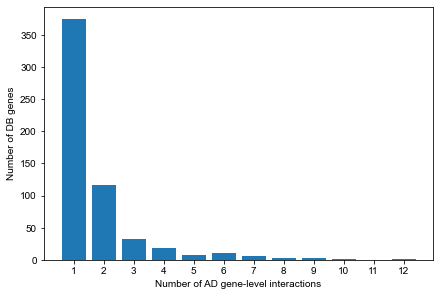

In [94]:
partner_degree = (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['Y2H_result'] == True),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())

fig, ax = plt.subplots(1, 1)
db_deg = partner_degree.value_counts()
plt.bar(db_deg.index.values, db_deg.values)
ax.set_xticks(range(1, partner_degree.max() + 1))
ax.set_ylabel('Number of DB genes')
ax.set_xlabel('Number of AD gene-level interactions')
plt.savefig('../figures/DB_gene_level_degree.pdf',
            bbox_inches='tight')

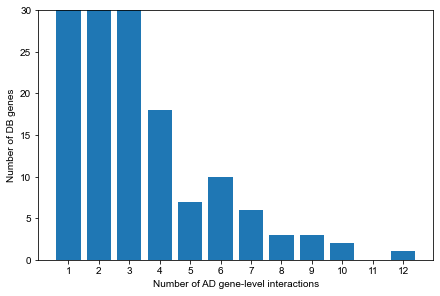

In [95]:
fig, ax = plt.subplots(1, 1)
ax.bar(db_deg.index.values, db_deg.values)
ax.set_xticks(range(1, partner_degree.max() + 1))
ax.set_ylabel('Number of DB genes')
ax.set_xlabel('Number of AD gene-level interactions')
ax.set_ylim(0, 30)
plt.savefig('../figures/DB_gene_level_degree_zoom.pdf',
            bbox_inches='tight')

In [96]:
# DEBUG
# pairs has been overwritten!

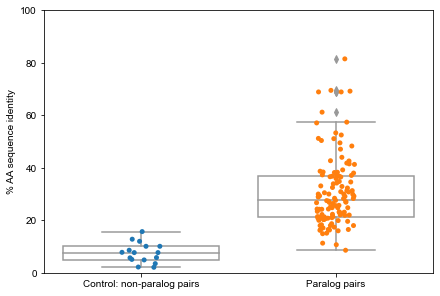

In [97]:
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=pairs, x='is_paralog_pair', y='pct_aa_seq_identity')
sns.boxplot(data=pairs, x='is_paralog_pair', y='pct_aa_seq_identity', color='white')
ax.set_ylim(0, 100)
ax.set_ylabel('% AA sequence identity')
ax.set_xticklabels(['Control: non-paralog pairs', 'Paralog pairs'])
ax.set_xlabel('')
plt.savefig('../figures/paralog_nonparalog_aa_identity.pdf',
            bbox_inches='tight')

In [98]:
# Takes a long time
# TODO: move this to its own notebook
for i, row in pairs.iterrows():
    break  # TMP
    fig, ax = plt.subplots(1, 1)
    a = row['gene_symbol_a']
    b = row['gene_symbol_b']
    y2h_ppi_per_paralog_pair_plot(a, b, y2h, ax=ax)
    os.makedirs('../figures/paralog_pairs', exist_ok=True)
    plt.savefig('../figures/paralog_pairs/' + a + '_' + b + '.pdf',
                bbox_inches='tight')
    plt.close(fig)

In [99]:
#    - How many partners were negative in all pairwise tests?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['Y2H_result'] == True),
           'db_gene_symbol'].nunique()
print('Of {} tested partners, {} had at least one positive result'.format(a, b))

Of 753 tested partners, 574 had at least one positive result


In [100]:
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].unique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['Y2H_result'] == True),
           'db_gene_symbol'].unique()
c = set(a).difference(set(b))
# remove these interactions where none of the isoforms are positive
y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
        y2h['db_gene_symbol'].isin(c), :].head()

,large_plate_name,retest_pla,retest_pos,ad_gene_symbol,ad_clone_name,ad_orf_id,db_gene_symbol,db_orf_id,category,3AT,LW,empty_AD_3AT,empty_AD_LW,Y2H_result,seq_confirmation_3AT,seq_confirmation_LW,ad_clone_acc
158,TFfnlr07_001_002_003_004_005_006,2,A11,GLI1,GLI1-1,100352,STK36,100009376,tf_isoform_ppis,3,4,3,4,NaN,False,False,GLI1|1/3|10F09
159,TFfnlr07_001_002_003_004_005_006,2,A12,GLI1,GLI1-1,100352,SUFU,6119,tf_isoform_ppis,4,4,0,4,NaN,False,True,GLI1|1/3|10F09
170,TFfnlr07_001_002_003_004_005_006,2,B11,GLI1,GLI1-2,100670,STK36,100009376,tf_isoform_ppis,3,4,3,4,NaN,False,False,GLI1|2/3|10E09
171,TFfnlr07_001_002_003_004_005_006,2,B12,GLI1,GLI1-2,100670,SUFU,6119,tf_isoform_ppis,4,4,0,4,NaN,False,True,GLI1|2/3|10E09
182,TFfnlr07_001_002_003_004_005_006,2,C11,GLI1,GLI1-3,100225,STK36,100009376,tf_isoform_ppis,3,4,3,4,NaN,False,False,GLI1|3/3|10E08


In [101]:
print('Total TF genes with cloned isoforms: {}'.format(isoforms['gene_symbol'].nunique()))
print('Total TF genes with 2+ cloned isoforms: {}'.format(sum((isoforms.groupby('gene_symbol').count()>1)['clone_acc'])))
print('with ≥ 1 PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                        (y2h['Y2H_result'] == True), 
                                        'ad_gene_symbol'].nunique()))
print('with ≥ 2 isoforms with ≥ 1 successuful PPI test for the same partner: {}'
       .format(
        (((y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                   y2h['Y2H_result'].notnull(), 
                   :]
              .groupby(['ad_gene_symbol', 'db_gene_symbol'])
              ['ad_clone_acc']
              .nunique() # number of isoforms per partner with valid interactions
              >= 2)
              .reset_index()
              .groupby('ad_gene_symbol').sum() >= 2).sum().iat[0])
     )
)
print('with ≥ 2 isoforms with ≥ 1 PPI each: {}'
       .format(
          (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                   (y2h['Y2H_result'] == True), 
                   :]
              .groupby('ad_gene_symbol')
              ['ad_clone_acc']
              .nunique()
              >= 2).sum()  
         )
     )

Total TF genes with cloned isoforms: 310
Total TF genes with 2+ cloned isoforms: 247
with ≥ 1 PPI: 97
with ≥ 2 isoforms with ≥ 1 successuful PPI test for the same partner: 86
with ≥ 2 isoforms with ≥ 1 PPI each: 63


<ipython-input-101-e6e2b2be8d6d>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (((y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &


In [102]:
print('Total TF isoforms: {}'.format(isoforms['clone_acc'].nunique()))
print('with ≥ 1 PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                        (y2h['Y2H_result'] == True), 
                                        'ad_clone_acc'].nunique()))
print('with ≥ 1 successfully tested PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                                    y2h['Y2H_result'].notnull(), 
                                                    'ad_clone_acc'].nunique()))

Total TF isoforms: 758
with ≥ 1 PPI: 200
with ≥ 1 successfully tested PPI: 287


In [103]:
ppi.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result,ad_tf_family,db_tf_family,tf_family_ad,tf_family_db
0,ATF2|1/6|12H04,ATF2,ATF2,True,bZIP,bZIP,bZIP,bZIP
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN,bZIP,bZIP,bZIP,bZIP
4,ATF2|1/6|12H04,ATF2,JDP2,True,bZIP,bZIP,bZIP,bZIP
12,ATF2|2/6|09E05,ATF2,ATF2,True,bZIP,bZIP,bZIP,bZIP
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN,bZIP,bZIP,bZIP,bZIP


In [104]:
(ppi.shape[0],
 ppi['ad_gene_symbol'].nunique(),
 ppi['ad_clone_acc'].nunique(),
 ppi['db_gene_symbol'].nunique())

(3103, 63, 166, 500)

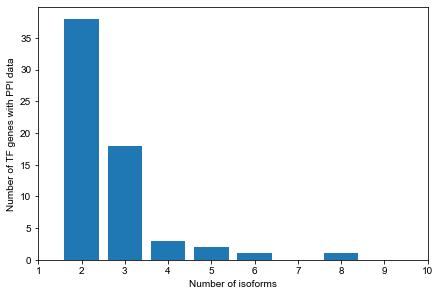

In [105]:
#    - Number of isoforms per TF gene

# remove isoform counts of 1?
n_iso = ppi.groupby('ad_gene_symbol').nunique()['ad_clone_acc']
fig, ax = plt.subplots(1, 1)
ax.bar(n_iso.value_counts().index,
       n_iso.value_counts().values)
ax.set_xticks(range(1, 11))
ax.set_xlabel('Number of isoforms')
ax.set_ylabel('Number of TF genes with PPI data')
plt.savefig('../figures/n_isoforms_per_gene_with_ppi_data.pdf',
            bbox_inches='tight')

In [106]:
ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol'].max()

160

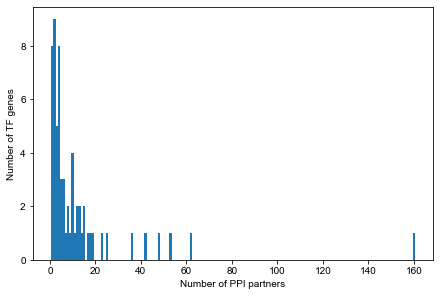

In [107]:
n_ppi = ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes')
plt.savefig('../figures/tf_gene_degree.pdf')

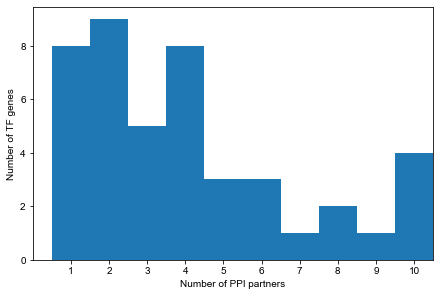

In [108]:
n_ppi = ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes')
ax.set_xlim(0, 10.5)
ax.set_xticks(range(1, 11))
plt.savefig('../figures/tf_gene_degree_zoom.pdf')

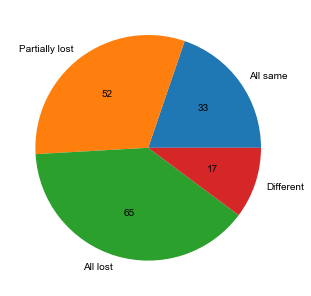

In [109]:
require_at_least_one_ppi_alt_per_isoform = False
ppi_alt = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'Y2H_result']].copy()
ppi_alt = ppi_alt.loc[ppi_alt.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['Y2H_result']
                 .transform(lambda row: (row == True).any()),
              :]
ppi_alt = ppi_alt.loc[ppi_alt.groupby('ad_clone_acc')
                  ['Y2H_result']
                  .transform(lambda x: (x.notnull().any())),
              :]
if require_at_least_one_ppi_alt_per_isoform:
    ppi_alt = ppi_alt.loc[ppi_alt.groupby('ad_clone_acc')['Y2H_result'].transform(lambda x: (x == True).any()),
                  :]
ppi_alt = ppi_alt.loc[ppi_alt.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]
cats = []
for gene_name in ppi_alt['ad_gene_symbol'].unique():
    tf = ppi_alt.loc[(ppi_alt['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'Y2H_result']].copy()
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='Y2H_result')
    ref_iso = tf.sum(axis=1).idxmax()
    for iso in tf.index:
        if iso == ref_iso:
            continue
        subset = tf.loc[[ref_iso, iso], 
                        tf.loc[ref_iso, :].notnull() &
                        tf.loc[iso, :].notnull()]    
        if (subset.loc[ref_iso, :] == subset.loc[iso, :]).all():
            cats.append('All same')
        elif subset.loc[iso, subset.columns[subset.loc[ref_iso, :] != True]].any():
            cats.append('Different')
        elif not subset.loc[iso, :].any():
            cats.append('All lost')
        else:
            cats.append('Partially lost')
counts = Counter(cats)
plt.pie(counts.values(),
        labels=counts.keys(),
        autopct=lambda x: '{:.0f}'.format((x / 100.) * sum(counts.values())))
plt.savefig('../figures/alt_isoforms_ppi_alts_pie_inc_no_ppi_alt.pdf',
            bbox_inches='tight')

In [110]:
# classify alternative isoforms by comparing to one with the most interactions
#    (1) all the same 
#    (2) none of those interactions and no others 
#    (3) some of those interactions
#    (4) some additional interactions
# minimum # interactions ?
# this kind-of works but has issues when the ppi with most interacions is tied and there is 

cats = []
for gene_name in ppi['ad_gene_symbol'].unique():
    tf = ppi.loc[(ppi['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'Y2H_result']].copy()
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='Y2H_result')
    ref_iso = tf.sum(axis=1).idxmax()
    for iso in tf.index:
        if iso == ref_iso:
            continue
        subset = tf.loc[[ref_iso, iso], 
                        tf.loc[ref_iso, :].notnull() &
                        tf.loc[iso, :].notnull()]    
        if (subset.loc[ref_iso, :] == subset.loc[iso, :]).all():
            cats.append('All same')
        elif subset.loc[iso, subset.columns[subset.loc[ref_iso, :] != True]].any():
            cats.append('Different')
        elif not subset.loc[iso, :].any():
            cats.append('All lost')
        else:
            cats.append('Partially lost')


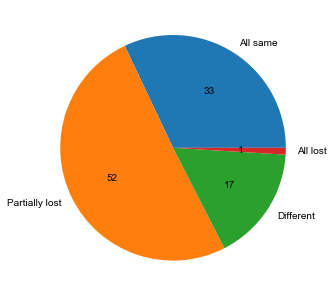

In [111]:
counts = Counter(cats)
plt.pie(counts.values(),
        labels=counts.keys(),
        autopct=lambda x: '{:.0f}'.format((x / 100.) * sum(counts.values())))
plt.savefig('../figures/alt_isoforms_ppis_pie.pdf',
            bbox_inches='tight')

In [112]:
# rewiring fraction
# add category


partners = (ppi.loc[(ppi['Y2H_result'] == True),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique()).rename('degree_gene_level').to_frame()

df = ppi.copy()
# require at least two successful isoform tests per ad gene
df = df.loc[df.groupby(['ad_gene_symbol', 'db_gene_symbol'])
              ['Y2H_result']
              .transform(lambda x: x.notnull().sum() >= 2),
            :]
partners['rewiring_score'] = 1 - (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                                     ['Y2H_result'].mean().reset_index().groupby('db_gene_symbol').mean())
partners = partners.dropna(subset=['rewiring_score'])
partners.head()

<ipython-input-112-273ccbd24167>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  partners['rewiring_score'] = 1 - (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])


,degree_gene_level,rewiring_score
db_gene_symbol,,
A1CF,1,0.428571
ACOT12,2,0.708333
AEBP2,1,0.333333
AES,6,0.298611
AGR2,1,0.500000


SignificanceResult(statistic=-0.08595153522817726, pvalue=0.05477206423565655)


<AxesSubplot: xlabel='degree_gene_level', ylabel='rewiring_score'>

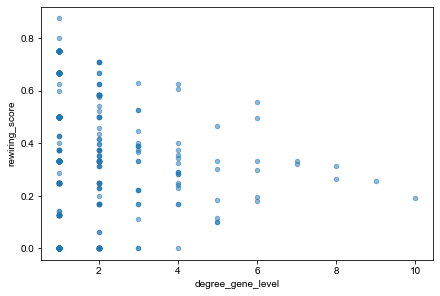

In [113]:

print(stats.spearmanr(partners['degree_gene_level'].values, partners['rewiring_score']))
partners.plot.scatter(x='degree_gene_level', 
                      y='rewiring_score',
                      alpha=0.5)

In [114]:
partners.sort_values('rewiring_score', ascending=False)

,degree_gene_level,rewiring_score
db_gene_symbol,,
ARL16,1,0.875
CRY2,1,0.800
RNF151,1,0.750
TRAF3,1,0.750
ZBTB6,1,0.750
...,...,...
NRBP1,1,0.000
NTF4,1,0.000
NUDT22,1,0.000


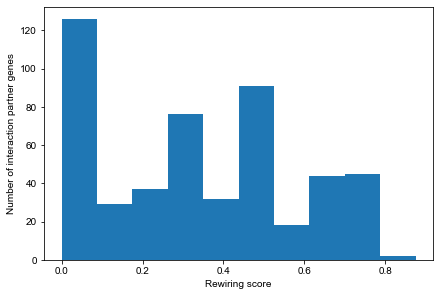

In [115]:
fig, ax = plt.subplots(1, 1)
partners['rewiring_score'].plot.hist()
ax.set_xlabel('Rewiring score')
ax.set_ylabel('Number of interaction partner genes')
plt.savefig('../figures/rewiring_dist.pdf',
            bbox_inches='tight')

In [116]:
partner_cats = load_ppi_partner_categories()
partner_cats.head()

,partner,category,cofactor_type
0,CITED2,cofactor,both
1,DPF2,cofactor,both
2,EMSY,cofactor,both
3,FHL2,cofactor,both
4,HR,cofactor,both


In [117]:
cats = partner_cats.groupby('category')['gene_symbol_partner'].apply(set).to_dict()
for cat, members in cats.items():
    partners['is_' + '_'.join(cat.split())] = partners.index.isin(members)

In [118]:
for col in partners.columns:
    if col.startswith('is_'):
        if not partners[col].any():
            continue
        print(col)
        print(stats.mannwhitneyu(partners.loc[partners[col], 'rewiring_score'].values,
                                 partners.loc[~partners[col], 'rewiring_score'].values))

is_DNA_polymerase
MannwhitneyuResult(statistic=481.5, pvalue=0.9367202960479168)
is_DNA_repair
MannwhitneyuResult(statistic=3245.0, pvalue=0.26490141789446175)
is_DNA_replication
MannwhitneyuResult(statistic=466.5, pvalue=0.2586976548520997)
is_RNA_processing
MannwhitneyuResult(statistic=6131.5, pvalue=0.9662443892707532)
is_RNA_turnover
MannwhitneyuResult(statistic=2312.5, pvalue=0.11794538907357399)
is_TF
MannwhitneyuResult(statistic=23100.0, pvalue=0.6116367393593247)
is_cell_cycle
MannwhitneyuResult(statistic=4899.5, pvalue=0.5845859123357053)
is_cell-cell_signaling
MannwhitneyuResult(statistic=993.5, pvalue=0.0511775361106993)
is_cofactor
MannwhitneyuResult(statistic=14970.5, pvalue=0.1993152198239806)
is_cytoskeleton
MannwhitneyuResult(statistic=6745.5, pvalue=0.9109155565055073)
is_membrane_protein
MannwhitneyuResult(statistic=346.5, pvalue=0.49872388643100773)
is_metabolism
MannwhitneyuResult(statistic=6658.0, pvalue=0.4845713923683541)
is_nuclear_transport
MannwhitneyuResult(s

In [119]:
hiu = huri.load_nw_hi_union(id_type='ensembl_gene_id')
lit = huri.load_nw_lit_17(id_type='ensembl_gene_id')
litb = lit.loc[lit['category'].isin(['Lit-BM', 'Lit-BS']), :].copy()
litbm = lit.loc[lit['category'].isin(['Lit-BM']), :].copy()

def map_gene_names(nw):
    return set(huri.map_nw_ids(nw, 'ensembl_gene_id', 'hgnc_symbol').index)

hiu = map_gene_names(hiu)
lit = map_gene_names(lit)
litbm = map_gene_names(litbm)
litb = map_gene_names(litb)

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/ccsblib/huri/internal_data/load_networks.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hi = pd.read_sql(qry, paros_connection())
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/ccsblib/huri/internal_data/load_networks.py:61: FutureWarning: The default value of regex will change from True to False in a future version.
  hi['ensembl_gene_id_a'] = hi['ensembl_gene_id_a'].str.replace(r'\..*', '')
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/ccsblib/huri/internal_data/load_networks.py:62: FutureWarning: The default value of regex will change from True to False in a future version.
  hi['ensembl_gene_id_b'] = hi['ensembl_gene_id_b'].str.replace(r'\..*', '')
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8

In [120]:
new_ppis = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['Y2H_result'] == True),
                        ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().copy()
new_ppis = set((new_ppis[['ad_gene_symbol', 'db_gene_symbol']].min(axis=1) + '_' +
               new_ppis[['ad_gene_symbol', 'db_gene_symbol']].max(axis=1)).drop_duplicates().values)

In [121]:
print('Total number of PPIs at isoform-level: {}'
        .format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['Y2H_result'] == True), ].shape[0]))
print('Gene-gene PPIs: {}'.format(len(new_ppis)))
print('Not in HI-Union: {}'.format(len(new_ppis.difference(hiu))))
print('Not in HI-Union or Lit-BM: {}'.format(len(new_ppis.difference(hiu.union(litbm)))))
print('Not in HI-Union or Lit-B: {}'.format(len(new_ppis.difference(hiu.union(litb)))))
print('Not in HI-Union or Lit-NB: {}'.format(len(new_ppis.difference(hiu.union(lit)))))

Total number of PPIs at isoform-level: 2259
Gene-gene PPIs: 992
Not in HI-Union: 475
Not in HI-Union or Lit-BM: 467
Not in HI-Union or Lit-B: 467
Not in HI-Union or Lit-NB: 440
